<a href="https://colab.research.google.com/github/hawkeyedatatsai/Stroke-Prediction/blob/main/Stroke_Prediction_with_PCA_feature_engineering_bring_back.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import set_config
set_config(display='diagram')
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_auc_score 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import precision_recall_curve, auc

#Data Dictionary

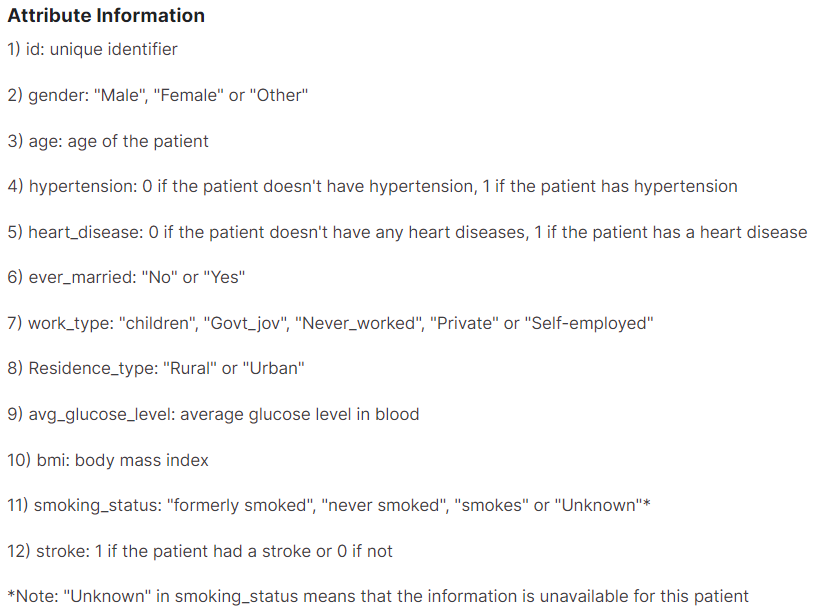

#Data Cleaning
The following topics will be addressed
- Deleted unnecessary columns.
- Deleted duplicate rows.
- Identified and addressed missing values.
- Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats).
- Produced univariate visuals for the target and all features.
- Identified outliers.
- Clearly commented all of your cleaning steps and described any decisions you made.

In [2]:
filename = "/content/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
#decide to drop id since it doesnt help us make prediction
df = df.drop(["id"], axis=1)

In [4]:
df.duplicated().sum()
#suggest no duplicate

0

In [5]:
df.isna().sum()/len(df)*100
#slight missing values on BMI, can fill it back with simpleimputer later

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [6]:
#check for inconsistent values in categorical columns
for col in list(df.select_dtypes(include='object')):
  print(col)
  print(df[col].value_counts())
  print()
#will drop "other" on gender since its very minor
#Plan to keep "Unknown" in smoking_status because its a huge portion of the col

gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



In [7]:
df[df["gender"] == 'Other']
df.drop(df.loc[df["gender"] == 'Other'].index, inplace=True)
print(df.describe())
df.describe(include="object")

               age  hypertension  heart_disease  avg_glucose_level  \
count  5109.000000   5109.000000    5109.000000        5109.000000   
mean     43.229986      0.097475       0.054022         106.140399   
std      22.613575      0.296633       0.226084          45.285004   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.240000   
50%      45.000000      0.000000       0.000000          91.880000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

              bmi       stroke  
count  4908.00000  5109.000000  
mean     28.89456     0.048738  
std       7.85432     0.215340  
min      10.30000     0.000000  
25%      23.50000     0.000000  
50%      28.10000     0.000000  
75%      33.10000     0.000000  
max      97.60000     1.000000  


,gender,ever_married,work_type,Residence_type,smoking_status
count,5109,5109,5109,5109,5109
unique,2,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2924,2596,1892


- [From this link](https://my.clevelandclinic.org/health/diagnostics/12363-blood-glucose-test) , glucose level between 70-99 mg/dl is considered normal whilst 100-125 suggests prediabetes. If the blood glucose level is 126 mg/dl (7.0 mmol/L) or higher on more than one testing occasion, it usually means diabetes. Therefore, I do not plan to change anything on "avg_glucose_level".

- max bmi 97 is still in reasonable range when talking abt extreme obesity scenario.


In [8]:
#Feature ranking with recursive feature elimination
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
#class sklearn.feature_selection.RFE(estimator, *, n_features_to_select=None, 
                                    #step=1, verbose=0, importance_getter='auto')

#Exploratory Data

##On each and individual columns

In [9]:
#Strategy
#stroke, hypertension and heart_disease are binary variable -> pie chart
#categorial data -> barplot
#numercial data -> histogram

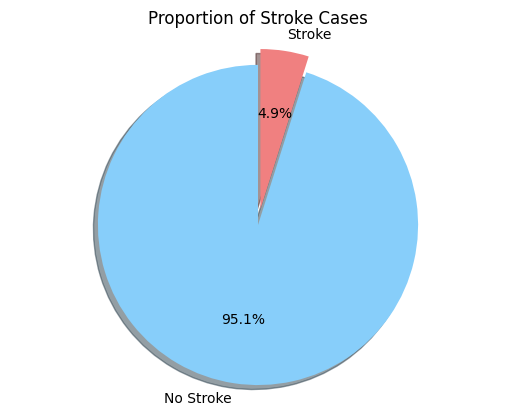

In [10]:
#TARGET!!
stroke_count = df['stroke'].value_counts()
labels = ['No Stroke', 'Stroke']
colors = ['lightskyblue', 'lightcoral']
explode = (0, 0.1)
plt.pie(stroke_count, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Proportion of Stroke Cases')
plt.show()

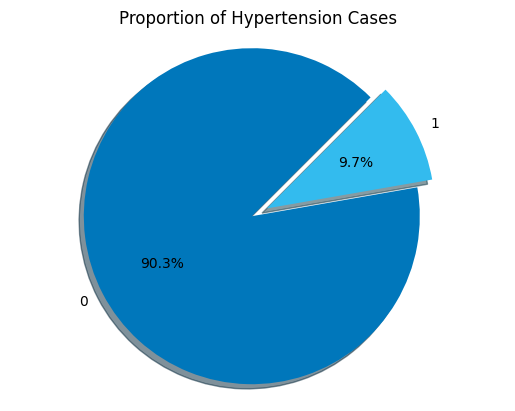

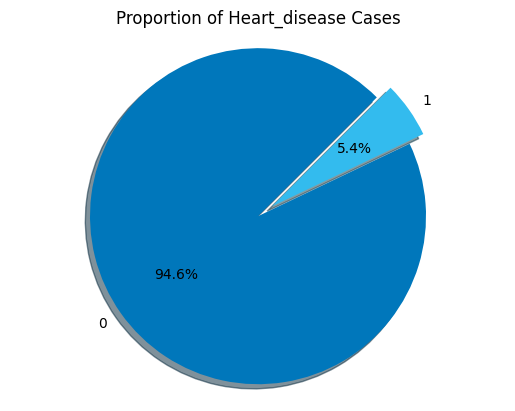

In [11]:
columns = ['hypertension', 'heart_disease']

#create a pie chart for these two columns
for column in columns:
    column_count = df[column].value_counts()
    labels = [str(x) for x in column_count.index]
    colors = ['#0077BB', '#33BBEE']
    explode = (0, 0.1)
    plt.pie(column_count, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=45)
    plt.axis('equal')
    plt.title(f"Proportion of {column.capitalize()} Cases")
    plt.show()

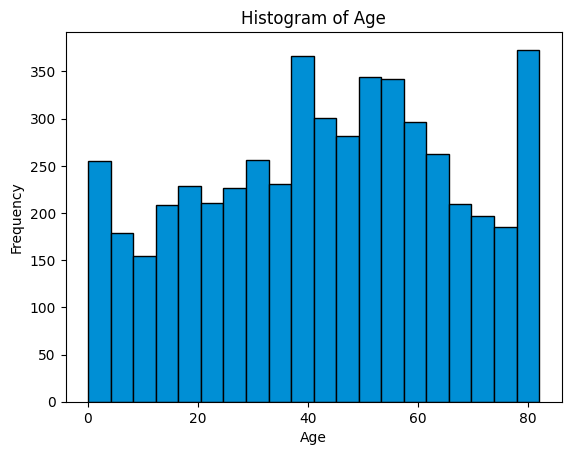

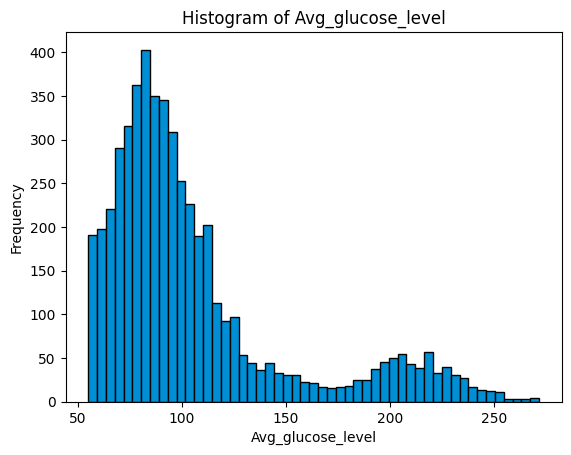

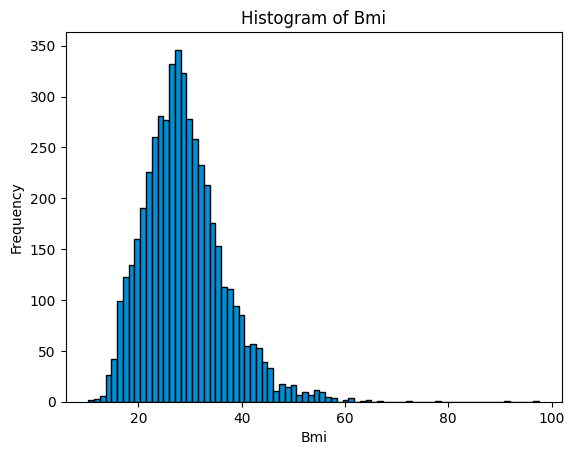

In [12]:
#create histograms for each numerical column
for col in ['age', 'avg_glucose_level', 'bmi']:
    plt.hist(df[col], bins="auto", color='#008fd5', edgecolor="black")
    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col.capitalize()}')
    plt.show()

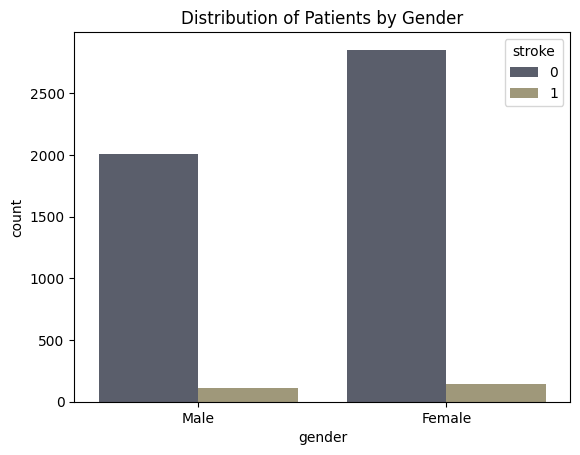

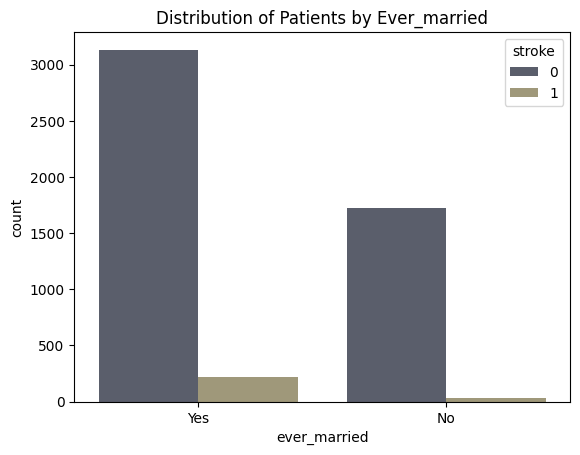

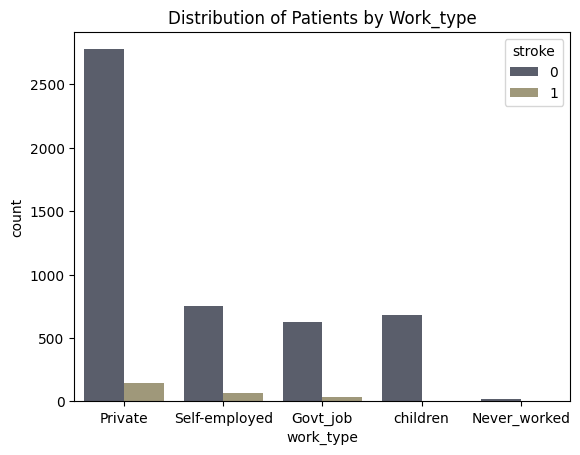

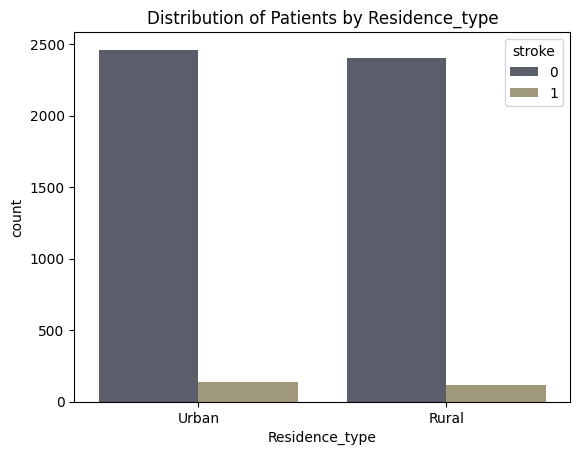

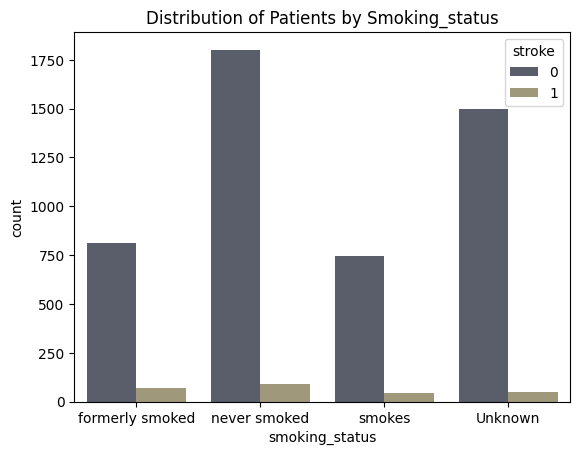

In [13]:
##present every categorial data with countplots
for col in df.select_dtypes(include='object').columns:
    sns.countplot(x=col, data=df, hue='stroke', palette='cividis')
    plt.title(f'Distribution of Patients by {col.capitalize()}')
    plt.show()

From countplot above, it is observed that the following characters have more stroke in its feature.

- female
- married
- living at urban
- working in private sector
- never smoked

##Identifying correlations between target and features

In [14]:
#interested to know how smoking status is correlated with stroke
#decide to manually transform categorial col to #
df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1})
df['gender'].value_counts()

0    2994
1    2115
Name: gender, dtype: int64

In [15]:
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
df['ever_married'].value_counts()

1    3353
0    1756
Name: ever_married, dtype: int64

In [16]:
df['work_type'] = df['work_type'].replace({'Never_worked': 0, 'children': 1, 'Govt_job': 2, 'Self-employed': 3, 'Private': 4 })
df['work_type'].value_counts()

4    2924
3     819
1     687
2     657
0      22
Name: work_type, dtype: int64

In [17]:
df['Residence_type'] = df['Residence_type'].replace({'Urban': 0, 'Rural': 1})
df['Residence_type'].value_counts()

0    2596
1    2513
Name: Residence_type, dtype: int64

In [18]:
df['smoking_status'] = df['smoking_status'].replace({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3 })
df['smoking_status'].value_counts()

1    1892
3    1544
0     884
2     789
Name: smoking_status, dtype: int64

<Axes: >

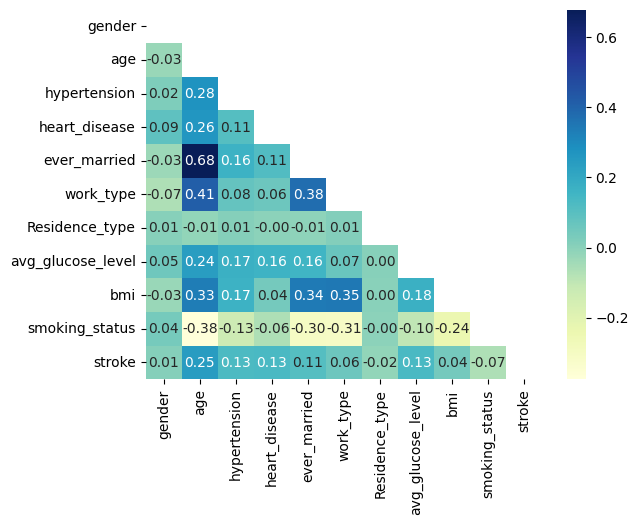

In [19]:
# Correlation Heatmap
corr = df.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cmap = 'YlGnBu', annot = True, fmt=".2f", mask = mask)

other than "age" columns, target "stroke" has very limit correlation with others. Note that age has has significant correlation with most other columns. 

##Creating multivariate visualizations to further understand data

###Scatter Plot

Text(0, 0.5, 'BMI')

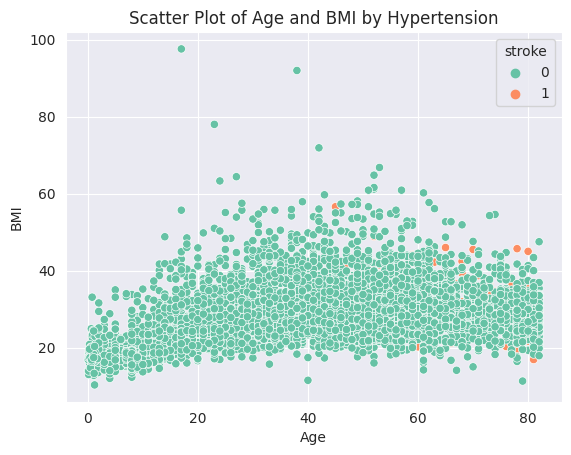

In [20]:
sns.set_style('darkgrid')
sns.scatterplot(y ='bmi', x = 'age', data = df, hue = 'stroke', palette='Set2')
plt.title('Scatter Plot of Age and BMI by Hypertension')
plt.xlabel('Age')
plt.ylabel('BMI')
#Interested to see what its like if i can separate 0 and 1 stroke

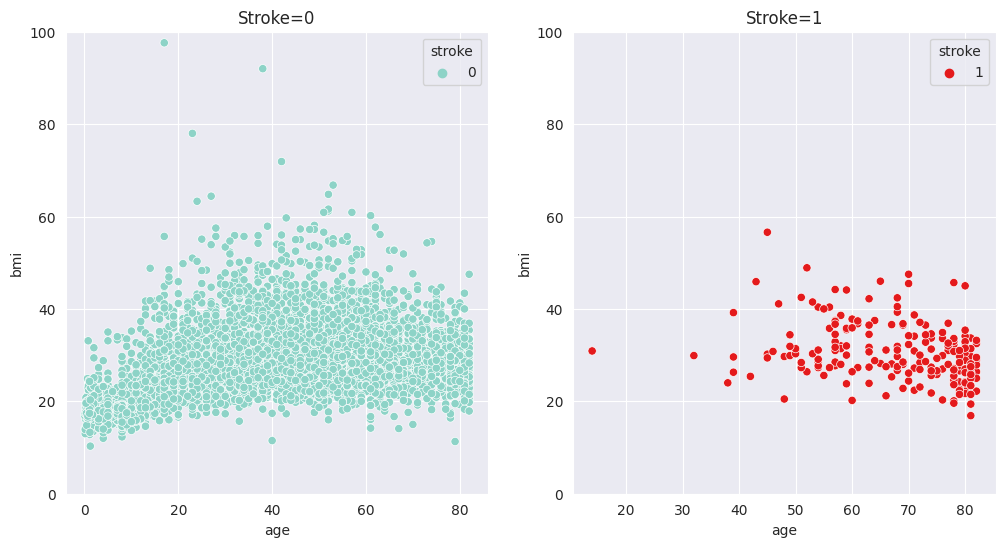

In [21]:
#dataframes for stroke=0 and 1 individually
df_stroke_0 = df[df['stroke'] == 0]
df_stroke_1 = df[df['stroke'] == 1]

#set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

#scatterplot for stroke=0
sns.scatterplot(ax=ax1, x='age', y='bmi', data=df_stroke_0, hue='stroke', palette='Set3')
ax1.set_title('Stroke=0')

#scatterplot for stroke=1
sns.scatterplot(ax=ax2, x='age', y='bmi', data=df_stroke_1, hue='stroke', palette='Set1')
ax2.set_title('Stroke=1')

#set y-limits for both plots to be the same scale
ax1.set_ylim(0, 100)
ax2.set_ylim(0, 100)

plt.show()


###Bar Plot

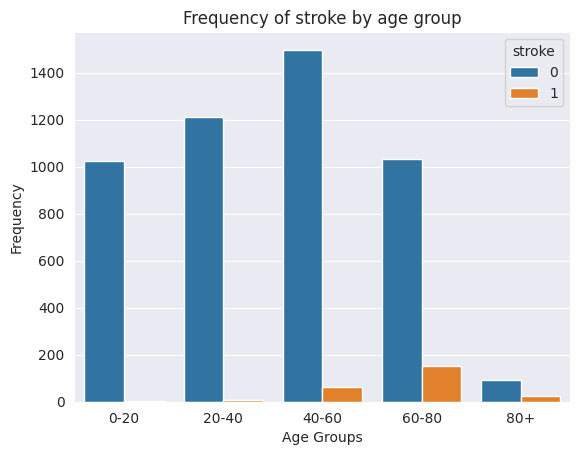

In [22]:
#create age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '20-40', '40-60', '60-80', '80+'])

sns.countplot(x='age_group', hue='stroke', data=df)

plt.title('Frequency of stroke by age group')
plt.xlabel('Age Groups')
plt.ylabel('Frequency')

plt.show()

###Line Plot

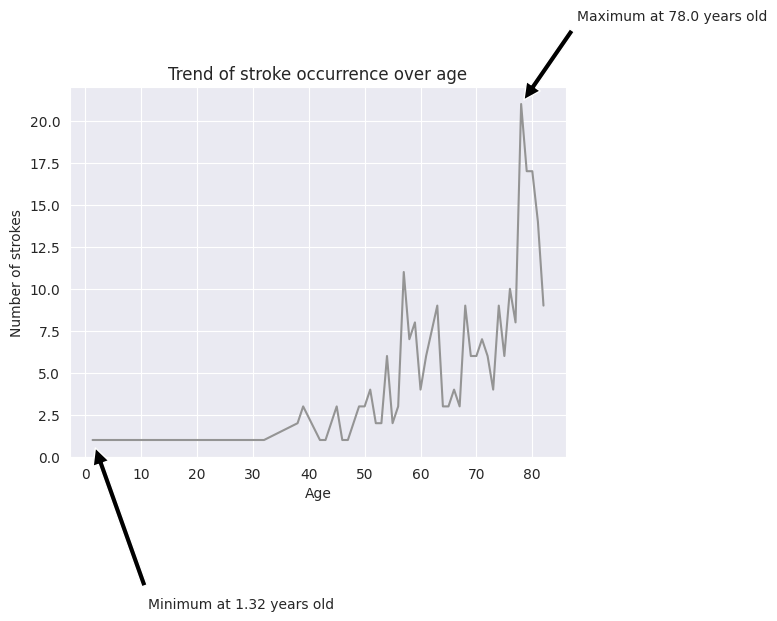

In [23]:
#grouby age and stroke count data
age_stroke_counts = df[df['stroke']==1].groupby(['age'])['stroke'].count().reset_index(name='count')

#plot the line
plt.plot(age_stroke_counts['age'], age_stroke_counts['count'], color=sns.color_palette("colorblind")[7])

#add annotation for the highest count
max_count = age_stroke_counts['count'].max()
max_count_age = age_stroke_counts[age_stroke_counts['count']==max_count]['age'].values[0]
plt.annotate(f'Maximum at {max_count_age} years old', xy=(max_count_age, max_count), xytext=(max_count_age+10, max_count+5), 
             arrowprops=dict(facecolor='black', shrink=0.05))


#get age with the minimum stroke count
min_count = age_stroke_counts['count'].min()
min_count_age = age_stroke_counts[age_stroke_counts['count'] == min_count]['age'].values[0]
plt.annotate(f'Minimum at {min_count_age} years old', xy=(min_count_age, min_count), xytext=(min_count_age+10, min_count-10), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlabel('Age')
plt.ylabel('Number of strokes')
plt.title('Trend of stroke occurrence over age')

plt.show()


##Summary



*   From scatterplots , it is shown that strokes occurs on older population especially after 50 years old.

*   Bar chart above suggest most of the stroke patient are within the age group of 60 to 80 years old.

*   Line plot suggests the trend of stroke occurrence throughout different age. It is observed that there is a spike on mid to late 50s, also found that most of ppl with stroke is on age of 78.









#Supervised Mahcine Learning Models

##Game Plan
This is a classification dataset and below are what I plan to do:

1. Making preprocessor.

2. Finding the best resampling method between oversampling and SMOTE on each machine learning models. The reason I chooe oversampling and SMOTE is because I need more data to study, rather than downsizing an abundant data possibly lost majority of information. 

3. Hyptertuning each machine learning models that has the best resampling method.

4. All models are compared with a custom function I wrote for classification problem.

In [24]:
original_df = df.copy()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5109 non-null   int64   
 1   age                5109 non-null   float64 
 2   hypertension       5109 non-null   int64   
 3   heart_disease      5109 non-null   int64   
 4   ever_married       5109 non-null   int64   
 5   work_type          5109 non-null   int64   
 6   Residence_type     5109 non-null   int64   
 7   avg_glucose_level  5109 non-null   float64 
 8   bmi                4908 non-null   float64 
 9   smoking_status     5109 non-null   int64   
 10  stroke             5109 non-null   int64   
 11  age_group          5109 non-null   category
dtypes: category(1), float64(3), int64(8)
memory usage: 484.2 KB


In [26]:
#split data
y = df['stroke']
X = df.drop(columns =['stroke', 'age_group']) 
#drop age_group to avoid data leakage
X.shape

(5109, 10)

In [27]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#check balance of target data
print(y.value_counts(normalize= True))
print('\n')
y.value_counts()
#results shows an inbalanced data where most are 0s
#baseline for 0 and 1 = 95.1% and 4.9%

0    0.951262
1    0.048738
Name: stroke, dtype: float64




0    4860
1     249
Name: stroke, dtype: int64

##Completing the appropriate pre-processing steps

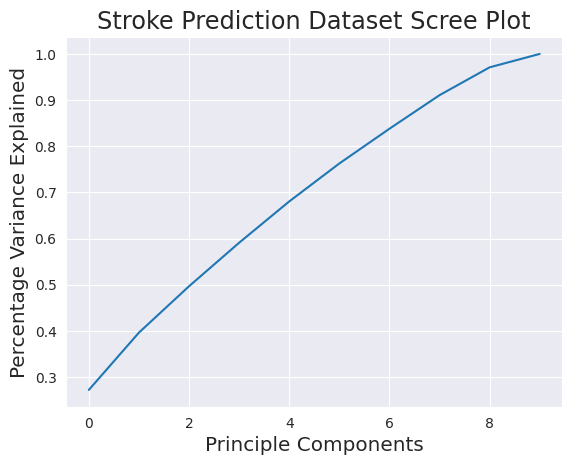

In [28]:
pca = PCA()
#on numeric
scaler = StandardScaler()
mean_imputer = SimpleImputer(strategy='mean')
num_pipeline = make_pipeline(mean_imputer, scaler)
num_selector = make_column_selector(dtype_include="number")
num_tuple = (num_pipeline, num_selector)

#on ordinal
ord = OrdinalEncoder()
ord_pipeline = make_pipeline(ord, scaler)
ord_selector = make_column_selector(dtype_include="category")
ord_tuple = (ord_pipeline, ord_selector)

# Instantiate the make column transformer
preprocessor = make_column_transformer(num_tuple, ord_tuple, remainder="drop", verbose_feature_names_out=False)
# Fit to X train
preprocessor.fit(X_train)
# Use PCA to determine the optimal number of components
pca.fit_transform(preprocessor.transform(X_train))
# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Stroke Prediction Dataset Scree Plot", fontsize="xx-large")
plt.show()

In [29]:
#decide to select PCA with 7 components, we will only use 70% (7/10) of features 
#but still receive 90% effect
pca7 = PCA(n_components=7)

##Ideitifying Resampling methods work best for Machine Learning Models 

In [30]:
# create dataframe to save model evaluation scores in
class_metrics_df = pd.DataFrame(columns = ['Train Accuracy', 'Test Accuracy', 'Train Recall (Sensitivity)', 'Test Recall (Sensitivity)', 'Train Precision', 'Test Precision', 'Train Specificity', 'Test Specificity', 'Train F1', 'Test F1', 'Train AUPRC', 'Test AUPRC'])
class_metrics_df

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC


In [31]:
def classification_metrics(model_pipe, X_train, X_test, y_train, y_test, name):
    y_train_pred = model_pipe.predict(X_train)
    class_metrics_df.at[name, 'Train Accuracy'] = round(accuracy_score(y_train, y_train_pred), 3)
    class_metrics_df.at[name, 'Train Recall (Sensitivity)'] = round(recall_score(y_train, y_train_pred), 3)
    class_metrics_df.at[name, 'Train Precision'] = round(precision_score(y_train, y_train_pred), 3)
    class_metrics_df.at[name, 'Train F1'] = round(f1_score(y_train, y_train_pred), 3)
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    train_specificity = tn / (tn + fp)
    class_metrics_df.at[name, 'Train Specificity'] = round(train_specificity, 3)
    # Calculate AUPRC for training set
    precision, recall, _ = precision_recall_curve(y_train, y_train_pred)
    train_auprc = auc(recall, precision)
    class_metrics_df.at[name, 'Train AUPRC'] = round(train_auprc, 3)
    class_metrics_df.at[name, 'Train TP'] = round(tp / sum(y_train), 3) # normalized TP
    
    y_test_pred = model_pipe.predict(X_test)
    class_metrics_df.at[name, 'Test Accuracy'] = round(accuracy_score(y_test, y_test_pred), 3)
    class_metrics_df.at[name, 'Test Recall (Sensitivity)'] = round(recall_score(y_test, y_test_pred), 3)
    class_metrics_df.at[name, 'Test Precision'] = round(precision_score(y_test, y_test_pred), 3)
    class_metrics_df.at[name, 'Test F1'] = round(f1_score(y_test, y_test_pred), 3)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    test_specificity = tn / (tn + fp)
    class_metrics_df.at[name, 'Test Specificity'] = round(test_specificity, 3)
    # Calculate AUPRC for test set
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    test_auprc = auc(recall, precision)
    class_metrics_df.at[name, 'Test AUPRC'] = round(test_auprc, 3)
    class_metrics_df.at[name, 'Test TP'] = round(tp / sum(y_test), 3) # normalized TP


###Support Vector Classifier

In [32]:
#default svc
svc = SVC()
svc_pipe = make_pipeline(preprocessor, svc)
svc_pipe.fit(X_train, y_train)

# Measure how long it takes to train without PCA
%timeit svc_pipe.fit(X_train, y_train)

291 ms ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


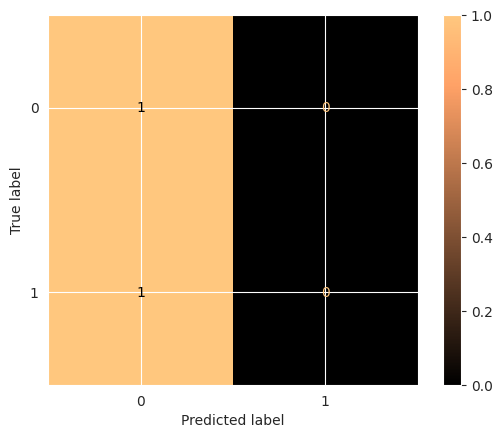

In [33]:
svc_predictions = svc_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, svc_predictions, display_labels=labels, cmap="copper", normalize="true")

In [34]:
#pca svc
pca_svc = SVC()
pca_svc_pipe = make_pipeline(preprocessor, pca7, pca_svc)
pca_svc_pipe.fit(X_train, y_train)

# Measure how long it takes to train with PCA
%timeit pca_svc_pipe.fit(X_train, y_train)

273 ms ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


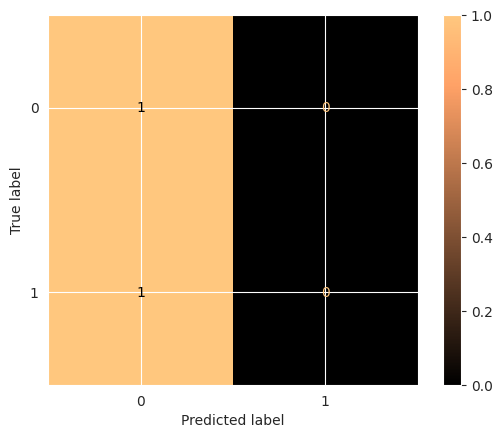

In [35]:
pca_svc_predictions = pca_svc_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pca_svc_predictions, display_labels=labels, cmap="copper", normalize="true")

In [36]:
#oversampling svc
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(preprocessor, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Create the oversampling modeling pipeline
svc_over = SVC()
over_sample_svc_pipe = make_sampler_pipeline(preprocessor, over_sampler, svc_over)
#Fit and evaluate the model
over_sample_svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a5f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a470>)],
                                   verbose_feature_names_out=False)),
                ('randomoversampler', RandomOverSampler()), ('svc', SVC())])

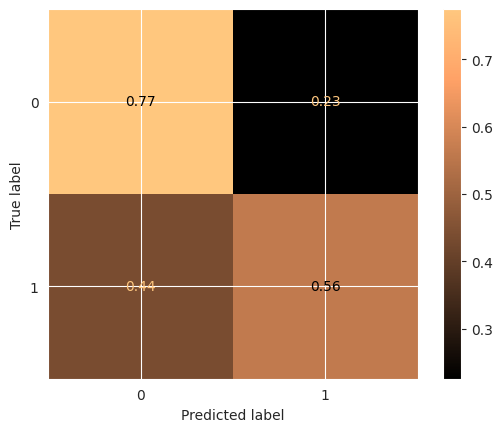

In [37]:
over_sample_svc_predictions = over_sample_svc_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, over_sample_svc_predictions, display_labels=labels, cmap="copper", normalize="true")

In [38]:
#SMOTE svc
smote = SMOTE()
svc_smote = SVC()
svc_smote_pipe = make_sampler_pipeline(preprocessor, smote, svc_smote)
#Fit and evaluate the model pipeline
svc_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a5f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a470>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()), ('svc', SVC())])

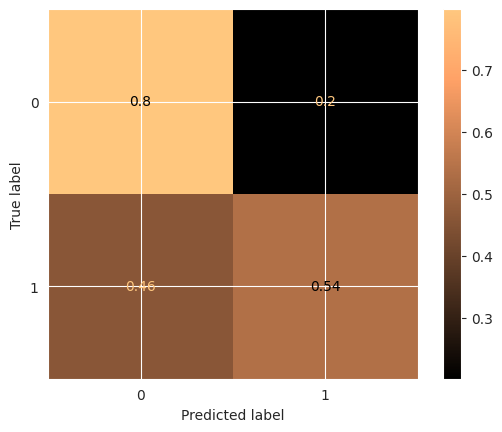

In [39]:
svc_smote_predictions = svc_smote_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, svc_smote_predictions, display_labels=labels, cmap="copper", normalize="true")

In [40]:
classification_metrics(svc_pipe, X_train, X_test, y_train, y_test, "SVC")
classification_metrics(pca_svc_pipe, X_train, X_test, y_train, y_test, "PCA SVC")
classification_metrics(over_sample_svc_pipe, X_train, X_test, y_train, y_test, "Oversampling SVC")
classification_metrics(svc_smote_pipe, X_train, X_test, y_train, y_test, "SMOTE SVC")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Logistic Regression

In [41]:
#default logreg
logreg = LogisticRegression()
logreg_pipe = make_pipeline(preprocessor, logreg)
logreg_pipe.fit(X_train, y_train)

# Measure how long it takes to train without PCA
%timeit logreg_pipe.fit(X_train, y_train)

23.4 ms ± 936 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


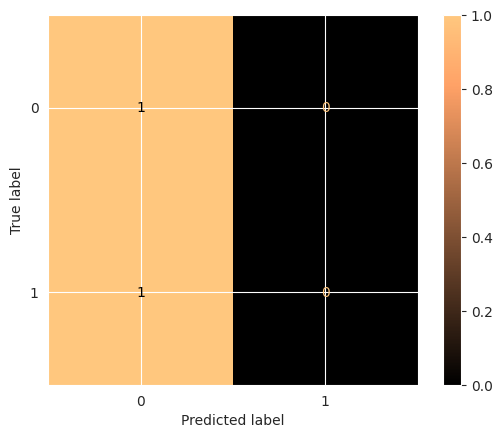

In [42]:
logreg_predictions = logreg_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, logreg_predictions, display_labels=labels, cmap="copper", normalize="true")

In [43]:
#pca logreg
pca_logreg = LogisticRegression()
pca_logreg_pipe = make_pipeline(preprocessor, pca7, pca_logreg)
pca_logreg_pipe.fit(X_train, y_train)

# Measure how long it takes to train with PCA
%timeit pca_logreg_pipe.fit(X_train, y_train)

40.3 ms ± 7.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


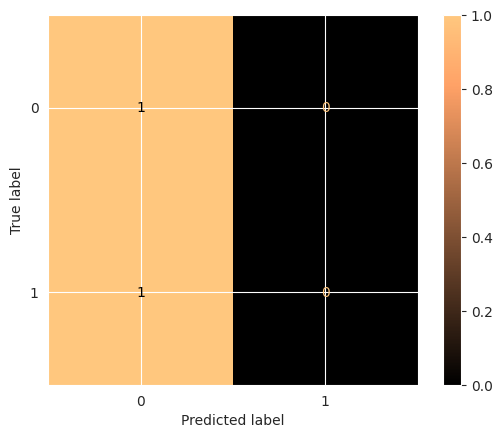

In [44]:
pca_logreg_predictions = pca_logreg_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pca_logreg_predictions, display_labels=labels, cmap="copper", normalize="true")

In [45]:
#oversampling logreg
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(preprocessor, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Create the oversampling modeling pipeline
log_reg_over = LogisticRegression()
over_sample_log_reg_pipe = make_sampler_pipeline(preprocessor, over_sampler, log_reg_over)
#Fit and evaluate the model
over_sample_log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a5f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a470>)],
                                   verbose_feature_names_out=False)),
                ('randomoversampler', RandomOverSampler()),
                ('logisticregression', LogisticRegression())])

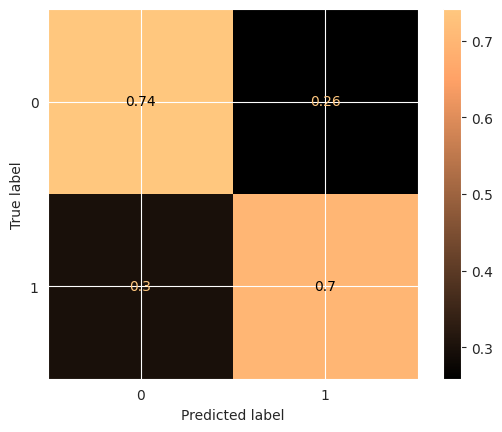

In [46]:
over_sample_log_reg_predictions = over_sample_log_reg_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, over_sample_log_reg_predictions, display_labels=labels, cmap="copper", normalize="true")

In [47]:
#SMOTE logreg
smote = SMOTE()
log_reg_smote = LogisticRegression()
log_reg_smote_pipe = make_sampler_pipeline(preprocessor, smote, log_reg_smote)
#Fit and evaluate the model pipeline
log_reg_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a5f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a470>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()),
                ('logisticregression', LogisticRegression())])

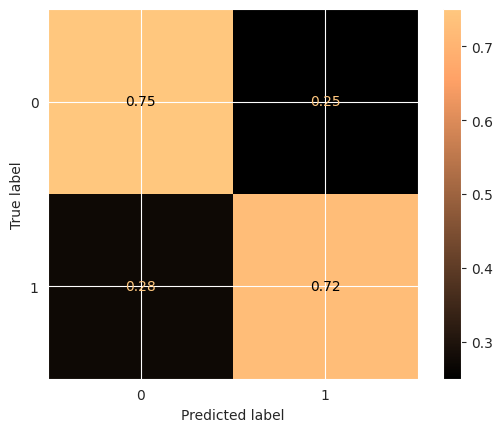

In [48]:
log_reg_smote_predictions = log_reg_smote_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, log_reg_smote_predictions, display_labels=labels, cmap="copper", normalize="true")

In [49]:
classification_metrics(logreg_pipe, X_train, X_test, y_train, y_test, "Logistic Regresion")
classification_metrics(pca_logreg_pipe, X_train, X_test, y_train, y_test, "PCA Logistic Regresion")
classification_metrics(over_sample_log_reg_pipe, X_train, X_test, y_train, y_test, "Oversampling Tuned Logistic Regresion")
classification_metrics(log_reg_smote_pipe, X_train, X_test, y_train, y_test, "SMOTE Logistic Regresion")
class_metrics_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
SVC,0.956,0.937,0.012,0.0,1.0,0.0,1.0,1.0,0.023,0.0,0.528,0.531,0.012,0.000
PCA SVC,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
Oversampling SVC,0.798,0.761,0.917,0.562,0.169,0.143,0.792,0.775,0.286,0.228,0.545,0.366,0.917,0.562
SMOTE SVC,0.81,0.782,0.893,0.538,0.175,0.151,0.806,0.798,0.293,0.236,0.537,0.359,0.893,0.538
Logistic Regresion,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
PCA Logistic Regresion,0.956,0.937,0.006,0.0,0.5,0.0,1.0,1.0,0.012,0.0,0.275,0.531,0.006,0.000
Oversampling Tuned Logistic Regresion,0.75,0.739,0.828,0.7,0.131,0.153,0.746,0.741,0.226,0.251,0.483,0.436,0.828,0.700
SMOTE Logistic Regresion,0.752,0.749,0.799,0.725,0.128,0.162,0.75,0.75,0.221,0.265,0.468,0.452,0.799,0.725


###Random Forest

In [50]:
#default rf
rf = RandomForestClassifier()
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)

# Measure how long it takes to train without PCA
%timeit rf_pipe.fit(X_train, y_train)

563 ms ± 99.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


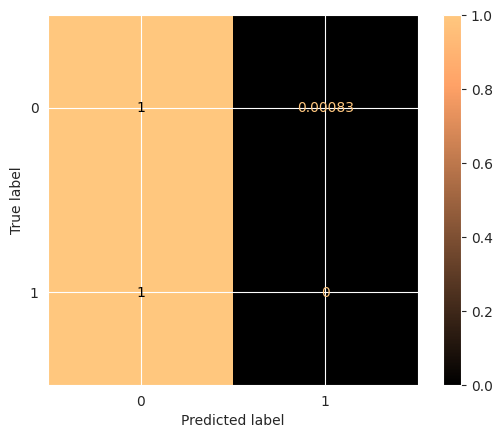

In [51]:
rf_predictions = rf_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, rf_predictions, display_labels=labels, cmap="copper", normalize="true")

In [52]:
#pca rf
pca_rf = RandomForestClassifier()
pca_rf_pipe = make_pipeline(preprocessor, pca7, pca_rf)
pca_rf_pipe.fit(X_train, y_train)

# Measure how long it takes to train with PCA
%timeit pca_rf_pipe.fit(X_train, y_train)

956 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
#oversampling rf
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(preprocessor, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Create the oversampling modeling pipeline
rf_over = RandomForestClassifier()
over_sample_rf_pipe = make_sampler_pipeline(preprocessor, over_sampler, rf_over)
#Fit and evaluate the model
over_sample_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a5f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a470>)],
                                   verbose_feature_names_out=False)),
                ('randomoversampler', RandomOverSampler()),
                ('randomforestclassifier', RandomForestClassifier())])

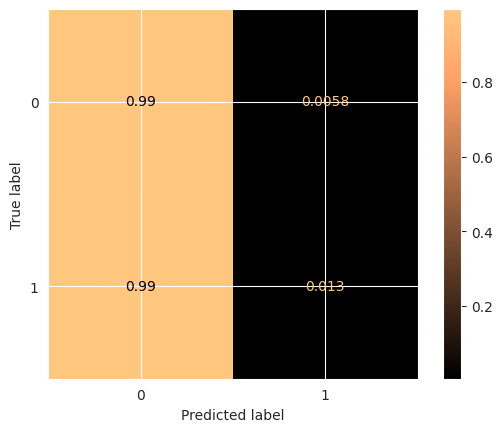

In [54]:
over_sample_rf_predictions = over_sample_rf_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, over_sample_rf_predictions, display_labels=labels, cmap="copper", normalize="true")

In [55]:
#SMOTE rf
smote = SMOTE()
rf_smote = RandomForestClassifier()
rf_smote_pipe = make_sampler_pipeline(preprocessor, smote, rf_smote)
#Fit and evaluate the model pipeline
rf_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a5f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a470>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()),
                ('randomforestclassifier', RandomForestClassifier())])

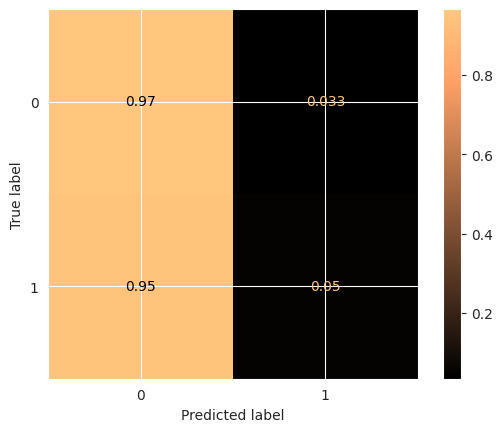

In [56]:
rf_smote_predictions = rf_smote_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, rf_smote_predictions, display_labels=labels, cmap="copper", normalize="true")

In [57]:
classification_metrics(rf_pipe, X_train, X_test, y_train, y_test, "Random Forest")
classification_metrics(pca_rf_pipe, X_train, X_test, y_train, y_test, "PCA Random Forest")
classification_metrics(over_sample_rf_pipe, X_train, X_test, y_train, y_test, "Oversampling Tuned Random Forest")
classification_metrics(rf_smote_pipe, X_train, X_test, y_train, y_test, "SMOTE Random Forest")
class_metrics_df

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
SVC,0.956,0.937,0.012,0.0,1.0,0.0,1.0,1.0,0.023,0.0,0.528,0.531,0.012,0.000
PCA SVC,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
Oversampling SVC,0.798,0.761,0.917,0.562,0.169,0.143,0.792,0.775,0.286,0.228,0.545,0.366,0.917,0.562
SMOTE SVC,0.81,0.782,0.893,0.538,0.175,0.151,0.806,0.798,0.293,0.236,0.537,0.359,0.893,0.538
Logistic Regresion,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
PCA Logistic Regresion,0.956,0.937,0.006,0.0,0.5,0.0,1.0,1.0,0.012,0.0,0.275,0.531,0.006,0.000
Oversampling Tuned Logistic Regresion,0.75,0.739,0.828,0.7,0.131,0.153,0.746,0.741,0.226,0.251,0.483,0.436,0.828,0.700
SMOTE Logistic Regresion,0.752,0.749,0.799,0.725,0.128,0.162,0.75,0.75,0.221,0.265,0.468,0.452,0.799,0.725
Random Forest,1.0,0.937,1.0,0.0,1.0,0.0,1.0,0.999,1.0,0.0,1.0,0.031,1.000,0.000
PCA Random Forest,1.0,0.937,1.0,0.012,1.0,0.5,1.0,0.999,1.0,0.024,1.0,0.287,1.000,0.012


###KNN

In [58]:
#default KNN
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)

# Measure how long it takes to train without PCA
%timeit knn_pipe.fit(X_train, y_train)

12.7 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


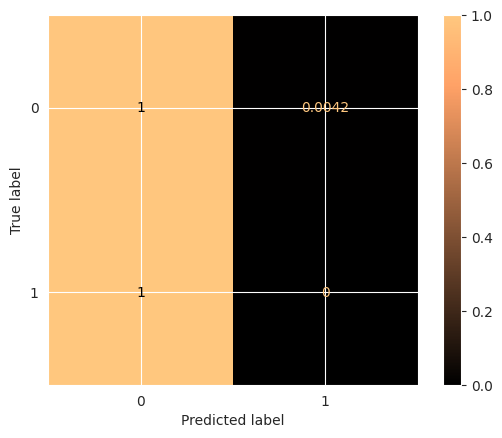

In [59]:
knn_predictions = knn_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, knn_predictions, display_labels=labels, cmap="copper", normalize="true")

In [60]:
#pca knn
pca_knn = KNeighborsClassifier()
pca_knn_pipe = make_pipeline(preprocessor, pca7, pca_knn)
pca_knn_pipe.fit(X_train, y_train)

# Measure how long it takes to train with PCA
%timeit pca_knn_pipe.fit(X_train, y_train)

32.1 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


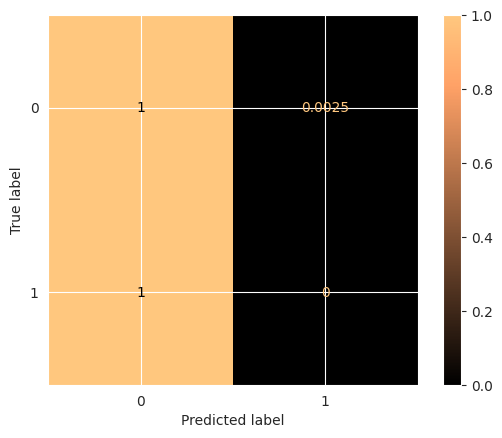

In [61]:
pca_knn_predictions = pca_knn_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pca_knn_predictions, display_labels=labels, cmap="copper", normalize="true")

In [62]:
#oversampling knn
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(preprocessor, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Create the oversampling modeling pipeline
knn_over = KNeighborsClassifier()
over_sample_knn_pipe = make_sampler_pipeline(preprocessor, over_sampler, knn_over)
#Fit and evaluate the model
over_sample_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a5f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a470>)],
                                   verbose_feature_names_out=False)),
                ('randomoversampler', RandomOverSampler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

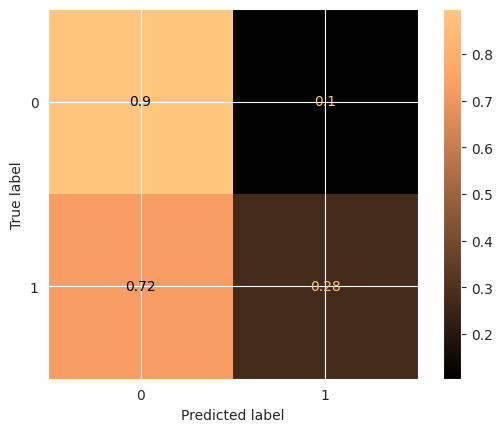

In [63]:
over_sample_knn_predictions = over_sample_knn_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, over_sample_knn_predictions, display_labels=labels, cmap="copper", normalize="true")

In [64]:
#SMOTE KNN
smote = SMOTE()
knn_smote = KNeighborsClassifier()
knn_smote_pipe = make_sampler_pipeline(preprocessor, smote, knn_smote)
#Fit and evaluate the model pipeline
knn_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a5f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a470>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()),
                ('kneighborsclassifier', KNeighborsClassifier())])

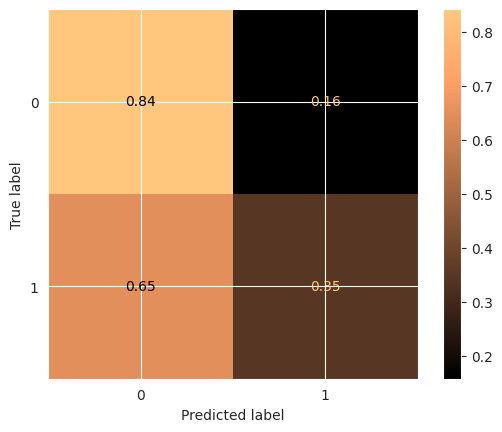

In [65]:
knn_smote_predictions = knn_smote_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, knn_smote_predictions, display_labels=labels, cmap="copper", normalize="true")

In [66]:
classification_metrics(knn_pipe, X_train, X_test, y_train, y_test, "KNN")
classification_metrics(pca_knn_pipe, X_train, X_test, y_train, y_test, "PCA KNN")
classification_metrics(over_sample_knn_pipe, X_train, X_test, y_train, y_test, "Oversampling KNN")
classification_metrics(knn_smote_pipe, X_train, X_test, y_train, y_test, "SMOTE KNN")
class_metrics_df

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
SVC,0.956,0.937,0.012,0.0,1.0,0.0,1.0,1.0,0.023,0.0,0.528,0.531,0.012,0.000
PCA SVC,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
Oversampling SVC,0.798,0.761,0.917,0.562,0.169,0.143,0.792,0.775,0.286,0.228,0.545,0.366,0.917,0.562
SMOTE SVC,0.81,0.782,0.893,0.538,0.175,0.151,0.806,0.798,0.293,0.236,0.537,0.359,0.893,0.538
Logistic Regresion,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
PCA Logistic Regresion,0.956,0.937,0.006,0.0,0.5,0.0,1.0,1.0,0.012,0.0,0.275,0.531,0.006,0.000
Oversampling Tuned Logistic Regresion,0.75,0.739,0.828,0.7,0.131,0.153,0.746,0.741,0.226,0.251,0.483,0.436,0.828,0.700
SMOTE Logistic Regresion,0.752,0.749,0.799,0.725,0.128,0.162,0.75,0.75,0.221,0.265,0.468,0.452,0.799,0.725
Random Forest,1.0,0.937,1.0,0.0,1.0,0.0,1.0,0.999,1.0,0.0,1.0,0.031,1.000,0.000
PCA Random Forest,1.0,0.937,1.0,0.012,1.0,0.5,1.0,0.999,1.0,0.024,1.0,0.287,1.000,0.012


###XGBooster

In [67]:
#XGBooster
xgb = XGBClassifier()
xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_pipe.fit(X_train, y_train)

# Measure how long it takes to train without PCA
%timeit xgb_pipe.fit(X_train, y_train)

346 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


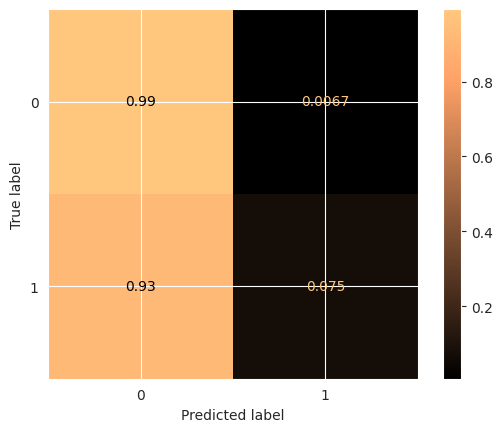

In [68]:
xgb_predictions = xgb_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, xgb_predictions, display_labels=labels, cmap="copper", normalize="true")

In [69]:
#pca XGBooster
pca_xgb = XGBClassifier()
pca_xgb_pipe = make_pipeline(preprocessor, pca7, pca_xgb)
pca_xgb_pipe.fit(X_train, y_train)

# Measure how long it takes to train with PCA
%timeit pca_xgb_pipe.fit(X_train, y_train)

971 ms ± 623 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


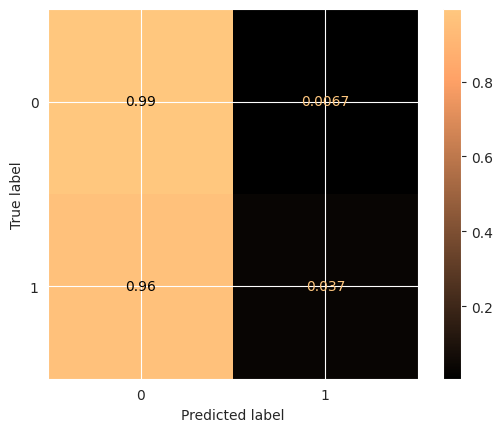

In [70]:
pca_xgb_predictions = pca_xgb_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pca_xgb_predictions, display_labels=labels, cmap="copper", normalize="true")

In [71]:
#oversampling XGBooster
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(preprocessor, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Create the oversampling modeling pipeline
xgb_over = XGBClassifier()
over_sample_xgb_pipe = make_sampler_pipeline(preprocessor, over_sampler, xgb_over)
#Fit and evaluate the model
over_sample_xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a5f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScale...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

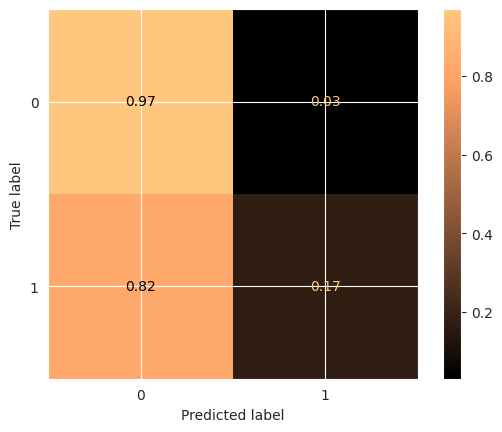

In [72]:
over_sample_xgb_predictions = over_sample_xgb_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, over_sample_xgb_predictions, display_labels=labels, cmap="copper", normalize="true")

In [73]:
#SMOTE XGBooster
smote = SMOTE()
xgb_smote = XGBClassifier()
xgb_smote_pipe = make_sampler_pipeline(preprocessor, smote, xgb_smote)
#Fit and evaluate the model pipeline
xgb_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe93223a5f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScale...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

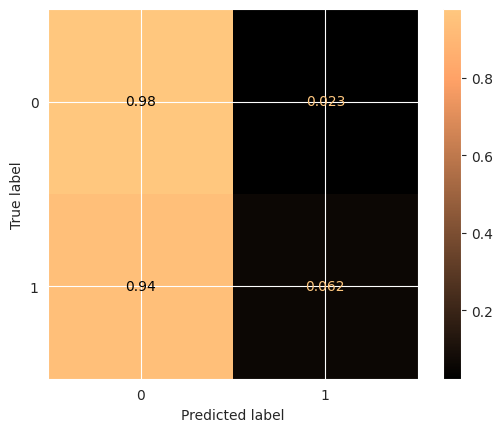

In [74]:
xgb_smote_predictions = xgb_smote_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, xgb_smote_predictions, display_labels=labels, cmap="copper", normalize="true")

In [75]:
classification_metrics(xgb_pipe, X_train, X_test, y_train, y_test, "XGB")
classification_metrics(pca_xgb_pipe, X_train, X_test, y_train, y_test, "PCA XGB")
classification_metrics(over_sample_xgb_pipe, X_train, X_test, y_train, y_test, "Oversampling XGB")
classification_metrics(xgb_smote_pipe, X_train, X_test, y_train, y_test, "SMOTE XGB")
class_metrics_df

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
SVC,0.956,0.937,0.012,0.0,1.0,0.0,1.0,1.0,0.023,0.0,0.528,0.531,0.012,0.000
PCA SVC,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
Oversampling SVC,0.798,0.761,0.917,0.562,0.169,0.143,0.792,0.775,0.286,0.228,0.545,0.366,0.917,0.562
SMOTE SVC,0.81,0.782,0.893,0.538,0.175,0.151,0.806,0.798,0.293,0.236,0.537,0.359,0.893,0.538
Logistic Regresion,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
PCA Logistic Regresion,0.956,0.937,0.006,0.0,0.5,0.0,1.0,1.0,0.012,0.0,0.275,0.531,0.006,0.000
Oversampling Tuned Logistic Regresion,0.75,0.739,0.828,0.7,0.131,0.153,0.746,0.741,0.226,0.251,0.483,0.436,0.828,0.700
SMOTE Logistic Regresion,0.752,0.749,0.799,0.725,0.128,0.162,0.75,0.75,0.221,0.265,0.468,0.452,0.799,0.725
Random Forest,1.0,0.937,1.0,0.0,1.0,0.0,1.0,0.999,1.0,0.0,1.0,0.031,1.000,0.000
PCA Random Forest,1.0,0.937,1.0,0.012,1.0,0.5,1.0,0.999,1.0,0.024,1.0,0.287,1.000,0.012


###Result

In [76]:
class_metrics_df.sort_values('Test TP', ascending=False)

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
SMOTE Logistic Regresion,0.752,0.749,0.799,0.725,0.128,0.162,0.75,0.75,0.221,0.265,0.468,0.452,0.799,0.725
Oversampling Tuned Logistic Regresion,0.75,0.739,0.828,0.7,0.131,0.153,0.746,0.741,0.226,0.251,0.483,0.436,0.828,0.700
Oversampling SVC,0.798,0.761,0.917,0.562,0.169,0.143,0.792,0.775,0.286,0.228,0.545,0.366,0.917,0.562
SMOTE SVC,0.81,0.782,0.893,0.538,0.175,0.151,0.806,0.798,0.293,0.236,0.537,0.359,0.893,0.538
SMOTE KNN,0.887,0.811,1.0,0.35,0.282,0.129,0.882,0.842,0.44,0.189,0.641,0.26,1.000,0.350
Oversampling KNN,0.929,0.858,1.0,0.275,0.382,0.151,0.925,0.896,0.553,0.195,0.691,0.236,1.000,0.275
Oversampling XGB,0.999,0.92,1.0,0.175,0.977,0.28,0.999,0.97,0.988,0.215,0.988,0.253,1.000,0.175
XGB,0.999,0.936,0.988,0.075,1.0,0.429,1.0,0.993,0.994,0.128,0.994,0.281,0.988,0.075
SMOTE XGB,0.998,0.919,0.953,0.062,0.994,0.152,1.0,0.977,0.973,0.088,0.974,0.136,0.953,0.062
SMOTE Random Forest,1.0,0.909,1.0,0.05,1.0,0.091,1.0,0.967,1.0,0.065,1.0,0.1,1.000,0.050


We want a model that can best predict true positive, especially on a imbalanced data like this, as much as possible. Therefore, I would emphasize on the column of Test TP. 

Since the resample logistic regresion model can predict more than 70% on true positives, so I am interested to know if I can tune to make it higher. Moreover, I will also tune Oversampling SVC and see if there is a chance we can reinforce it to around 70%. Finally, SMOTE KNN and XGBooster tuning will be presented for comparison purposes.

##Hypertuning each model

###SMOTE logistic regression

In [77]:
#tuned SMOTE logreg
smote = SMOTE()
tuned_log_reg_smote = LogisticRegression()
tuned_log_reg_smote_pipe = make_sampler_pipeline(preprocessor, smote, tuned_log_reg_smote)
#start tuning with GS
log_params = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
              'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
tuned_log_reg_smote_gs = GridSearchCV(tuned_log_reg_smote_pipe, log_params)
tuned_log_reg_smote_gs.fit(X_train, y_train)

#get best params
print(tuned_log_reg_smote_gs.best_params_)

# instantiate tuned model
best_tuned_log_reg_smote_pipe = tuned_log_reg_smote_gs.best_estimator_

{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'sag'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dua

###Oversampling SVC

In [78]:
#tuned oversampling svc
over_sampler = RandomOverSampler()
tuned_svc_over = SVC()
tuned_over_sample_svc_pipe = make_sampler_pipeline(preprocessor, over_sampler, tuned_svc_over)
#start tuning with GS
svc_params = {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf', 'poly'], 
              'svc__gamma': ['scale', 'auto']}
tuned_over_sample_svc_gs = GridSearchCV(tuned_over_sample_svc_pipe, svc_params)
tuned_over_sample_svc_gs.fit(X_train, y_train)

#get best params
print(tuned_over_sample_svc_gs.best_params_)

# instantiate tuned model
best_tuned_over_sample_svc_pipe = tuned_over_sample_svc_gs.best_estimator_

{'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}


###SMOTE KNN

In [79]:
#tuned SMOTE KNN
smote = SMOTE()
tuned_knn_smote = KNeighborsClassifier()
tuned_knn_smote_pipe = make_sampler_pipeline(preprocessor, smote, tuned_knn_smote)
#start tuning with GS
knn_params = {'kneighborsclassifier__n_neighbors' : [5,7,9,11,13,15],
          'kneighborsclassifier__weights' : ['uniform','distance'],
          'kneighborsclassifier__metric' : ['minkowski','euclidean','manhattan']}
tuned_knn_smote_gs = GridSearchCV(tuned_knn_smote_pipe, knn_params)
tuned_knn_smote_gs.fit(X_train, y_train)

#get best params
print(tuned_knn_smote_gs.best_params_)

# instantiate tuned model
best_tuned_knn_smote_pipe = tuned_knn_smote_gs.best_estimator_

{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}


###XGBooster

In [80]:
#tuned XGBooster
tuned_xgb = XGBClassifier()
tuned_xgb_pipe = make_pipeline(preprocessor, tuned_xgb)
#start tuning with GS
xgb_params = {'xgbclassifier__learning_rate' : [0.01,0.1,1, 10],
              'xgbclassifier__n_estimators': [1, 10, 15, 20, 25, 30],
          'xgbclassifier__max_depth': [1, 10]}
tuned_xgb_gs = GridSearchCV(tuned_xgb_pipe, xgb_params)
tuned_xgb_gs.fit(X_train, y_train)

#get best params
print(tuned_xgb_gs.best_params_)

# instantiate tuned model
best_tuned_xgb_pipe = tuned_xgb_gs.best_estimator_

{'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 1}


##Result

In [81]:
classification_metrics(best_tuned_log_reg_smote_pipe, X_train, X_test, y_train, y_test, "Tuned SMOTE Logistic Regresion")
classification_metrics(best_tuned_over_sample_svc_pipe, X_train, X_test, y_train, y_test, "Tuned Oversampling SVC")
classification_metrics(best_tuned_knn_smote_pipe, X_train, X_test, y_train, y_test, "Tuned SMOTE KNN")
classification_metrics(best_tuned_xgb_pipe, X_train, X_test, y_train, y_test, "Tuned XGB")
class_metrics_df.sort_values('Test TP', ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
Tuned SMOTE Logistic Regresion,0.753,0.747,0.811,0.725,0.13,0.162,0.75,0.749,0.225,0.264,0.475,0.452,0.811,0.725
SMOTE Logistic Regresion,0.752,0.749,0.799,0.725,0.128,0.162,0.75,0.75,0.221,0.265,0.468,0.452,0.799,0.725
Oversampling Tuned Logistic Regresion,0.75,0.739,0.828,0.7,0.131,0.153,0.746,0.741,0.226,0.251,0.483,0.436,0.828,0.700
Oversampling SVC,0.798,0.761,0.917,0.562,0.169,0.143,0.792,0.775,0.286,0.228,0.545,0.366,0.917,0.562
SMOTE SVC,0.81,0.782,0.893,0.538,0.175,0.151,0.806,0.798,0.293,0.236,0.537,0.359,0.893,0.538
SMOTE KNN,0.887,0.811,1.0,0.35,0.282,0.129,0.882,0.842,0.44,0.189,0.641,0.26,1.000,0.350
Tuned Oversampling SVC,0.88,0.813,0.959,0.338,0.264,0.127,0.877,0.845,0.414,0.184,0.612,0.253,0.959,0.338
Oversampling KNN,0.929,0.858,1.0,0.275,0.382,0.151,0.925,0.896,0.553,0.195,0.691,0.236,1.000,0.275
Tuned SMOTE KNN,1.0,0.839,1.0,0.262,1.0,0.125,1.0,0.877,1.0,0.169,1.0,0.217,1.000,0.262
Oversampling XGB,0.999,0.92,1.0,0.175,0.977,0.28,0.999,0.97,0.988,0.215,0.988,0.253,1.000,0.175


In [82]:
final_df = class_metrics_df[["Test F1", "Test AUPRC", "Test TP"]]
final_df.sort_values('Test TP', ascending=False)

,Test F1,Test AUPRC,Test TP
Tuned SMOTE Logistic Regresion,0.264,0.452,0.725
SMOTE Logistic Regresion,0.265,0.452,0.725
Oversampling Tuned Logistic Regresion,0.251,0.436,0.700
Oversampling SVC,0.228,0.366,0.562
SMOTE SVC,0.236,0.359,0.538
SMOTE KNN,0.189,0.26,0.350
Tuned Oversampling SVC,0.184,0.253,0.338
Oversampling KNN,0.195,0.236,0.275
Tuned SMOTE KNN,0.169,0.217,0.262
Oversampling XGB,0.215,0.253,0.175


#Apply the Best Model to original Data

In [83]:
X_train_processed = preprocessor.fit_transform(X_train)
#apply SMOTE on train data
smote = SMOTE()
X_train_processed_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

log_reg_smote = LogisticRegression()
log_reg_smote.fit(X_train_processed_smote, y_train_smote)

# preprocess original data
X_original_processed = preprocessor.transform(X)

# predict on original data with SMOTE
y_original_pred = log_reg_smote.predict(X_original_processed)

# add predicted values to original data
df['predicted_stroke'] = y_original_pred

#filter rows with actual and predicted values both equal to 1
correct_predictions = df[(df['stroke'] == 1) & (df['predicted_stroke'] == 1)]
correct_predictions

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,predicted_stroke
0,1,67.0,0,1,1,4,0,228.69,36.6,0,1,60-80,1
1,0,61.0,0,0,1,3,1,202.21,NaN,1,1,60-80,1
2,1,80.0,0,1,1,4,1,105.92,32.5,1,1,60-80,1
4,0,79.0,1,0,1,3,1,174.12,24.0,1,1,60-80,1
5,1,81.0,0,0,1,4,0,186.21,29.0,0,1,80+,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,1,68.0,0,0,1,4,1,233.94,42.4,1,1,60-80,1
243,0,68.0,1,1,1,4,0,247.51,40.5,0,1,60-80,1
246,0,75.0,0,0,1,3,1,78.80,29.3,0,1,60-80,1
247,1,71.0,1,0,1,3,1,87.80,NaN,3,1,60-80,1


#Feature Engineering

In [90]:
#high glucose level usually leads to hypertension and possible stroke
df['high_glucose'] = df['avg_glucose_level'].apply(lambda x: 1 if x > 125 else 0)
engineered_df = df.copy()
engineered_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,predicted_stroke,high_glucose
0,1,67.0,0,1,1,4,0,228.69,36.6,0,1,60-80,1,1
1,0,61.0,0,0,1,3,1,202.21,NaN,1,1,60-80,1,1
2,1,80.0,0,1,1,4,1,105.92,32.5,1,1,60-80,1,0
3,0,49.0,0,0,1,4,0,171.23,34.4,2,1,40-60,0,1
4,0,79.0,1,0,1,3,1,174.12,24.0,1,1,60-80,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,4,0,83.75,NaN,1,0,60-80,1,0
5106,0,81.0,0,0,1,3,0,125.20,40.0,1,0,80+,1,1
5107,0,35.0,0,0,1,3,1,82.99,30.6,1,0,20-40,0,0
5108,1,51.0,0,0,1,4,1,166.29,25.6,0,0,40-60,0,1


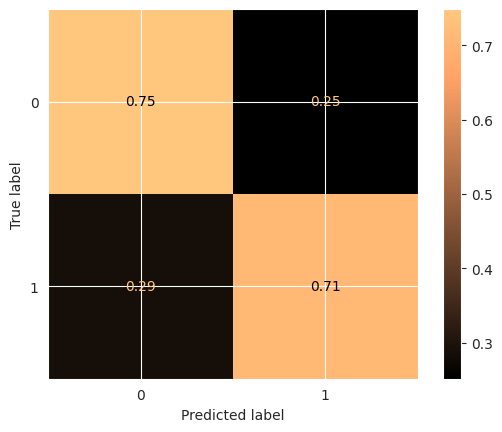

In [91]:
#split data
y = engineered_df['stroke']
X = engineered_df.drop(columns =['stroke', 'age_group']) 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pca = PCA()
#on numeric
scaler = StandardScaler()
mean_imputer = SimpleImputer(strategy='mean')
num_pipeline = make_pipeline(mean_imputer, scaler)
num_selector = make_column_selector(dtype_include="number")
num_tuple = (num_pipeline, num_selector)

#on ordinal
ord = OrdinalEncoder()
ord_pipeline = make_pipeline(ord, scaler)
ord_selector = make_column_selector(dtype_include="category")
ord_tuple = (ord_pipeline, ord_selector)

# Instantiate the make column transformer
preprocessor = make_column_transformer(num_tuple, ord_tuple, remainder="drop", verbose_feature_names_out=False)
# Fit to X train
preprocessor.fit(X_train)

#smote logreg
smote = SMOTE()
engineered_log_reg_smote = LogisticRegression()
engineered_log_reg_smote_pipe = make_sampler_pipeline(preprocessor, smote, engineered_log_reg_smote)
#Fit and evaluate the model pipeline
engineered_log_reg_smote_pipe.fit(X_train, y_train)

#evaluate
engineered_log_reg_smote_predictions = engineered_log_reg_smote_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, engineered_log_reg_smote_predictions, display_labels=labels, cmap="copper", normalize="true")

#Analysis and Recommendations

1. From data explainatory, it is observed that people with following traits could have stroke:

- age over 50
- female
- married
- living at urban
- working in private sector
- never smoked

2. Whilst applying machine learning on this dataset, the goal is to not only avoid type II error as much as possible but also have as many true positives as many as we can predict. Through the results above, it is observed that 

- Resampling method makes impact as all four models has TP>.5 are resampled.

- Tuning does not make impacts as tuned models have same or lower TP.

- SMOTE Logistic Regresion, tuned SMOTE Logistic Regresion and tuned oversampling Logistic Regresioncan can identify more than 70% of true positives (with stroke). These models are more likely to be used and applied in the real world.

3. Utilizing SMOTE Logistic Regresion and looking back to the original data where stroke are both actually and predcited happened, we can reduce the dataset to less than 200 rows. In fact, this will be a good starting point to reinforce our model by getting a better description of our data.

4. Featured engineering strategy is applied by creating one extra column 'high_glucose'. It has the similiar TP .72 as without feature engineering.


5. For comparison purposes, PCAs were applied and compared but it did not make significant impact on metrics performance. Maybe due to a relatively small dataset.

6. After having a reliable model, we can make various recommendations upon different audiences. For instance:

- General public: Be cautious on potential strok symptom if you fit the traits.

- Stakeholders of pharmaceutical companies: custom product development and marketing strategies upon different traits.


